In [0]:
import os
import scipy.misc
import numpy as np
import tensorflow as tf
import time
import math
import matplotlib.pyplot as plt


# Util function, no need to modify

def binary_cross_entropy(preds, targets, name=None):
    """Computes binary cross entropy given `preds`.
        For brevity, let `x = `, `z = targets`.  The logistic loss is
        loss(x, z) = - sum_i (x[i] * log(z[i]) + (1 - x[i]) * log(1 - z[i]))
    Args:
        preds: A `Tensor` of type `float32` or `float64`.
        targets: A `Tensor` of the same type and shape as `preds`.
    """
    eps = 1e-12
    with ops.op_scope([preds, targets], name, "bce_loss") as name:
        preds = ops.convert_to_tensor(preds, name="preds")
        targets = ops.convert_to_tensor(targets, name="targets")
        return tf.reduce_mean(-(targets * tf.log(preds + eps) +
                              (1. - targets) * tf.log(1. - preds + eps)))

def conv_cond_concat(x, y):
    """Concatenate conditioning vector on feature map axis."""
    x_shapes = x.get_shape()
    y_shapes = y.get_shape()
    return tf.concat(3, [x, y*tf.ones([x_shapes[0], x_shapes[1], x_shapes[2], y_shapes[3]])])

def conv2d(input_, output_dim, k_h=5, k_w=5, d_h=2, d_w=2, stddev=0.02, name="conv2d"):
    with tf.variable_scope(name):
        w = tf.get_variable('w', [k_h, k_w, input_.get_shape()[-1], output_dim],
                            initializer=tf.truncated_normal_initializer(stddev=stddev))
        conv = tf.nn.conv2d(input_, w, strides=[1, d_h, d_w, 1], padding='SAME')
        biases = tf.get_variable('biases', [output_dim], initializer=tf.constant_initializer(0.0))
        conv = tf.reshape(tf.nn.bias_add(conv, biases), conv.get_shape())
        return conv

def deconv2d(input_, output_shape, k_h=5, k_w=5, d_h=2, d_w=2, stddev=0.02, name="deconv2d"):
    with tf.variable_scope(name):
        # filter : [height, width, output_channels, in_channels]
        w = tf.get_variable('w', [k_h, k_w, output_shape[-1], input_.get_shape()[-1]],
                            initializer=tf.random_normal_initializer(stddev=stddev))
        try:
            deconv = tf.keras.layers.conv2d_transpose(input_, w, output_shape=output_shape,
                                strides=[1, d_h, d_w, 1])
        # Support for verisons of TensorFlow before 0.7.0
        except AttributeError:
            deconv = tf.nn.conv2d_transpose(input_, w, output_shape=output_shape,
                                strides=[1, d_h, d_w, 1])
        biases = tf.get_variable('biases', [output_shape[-1]], initializer=tf.constant_initializer(0.0))
        deconv = tf.reshape(tf.nn.bias_add(deconv, biases), deconv.get_shape())
        return deconv

def batch_norm(input, epsilon=1e-5, momentum=0.9, train=True, name="batch_norm"):
    return tf.contrib.layers.batch_norm(input, decay=momentum, updates_collections=None,
            epsilon=epsilon, scale=True, is_training=train, scope=name)

def lrelu(x, leak=0.2, name="lrelu"):
    return tf.maximum(x, leak*x)

def linear(input_, output_size, scope=None, stddev=0.02, bias_start=0.0, with_w=False):
    shape = input_.get_shape().as_list()
    with tf.variable_scope(scope or "Linear"):
        matrix = tf.get_variable("Matrix", [shape[1], output_size], tf.float32,
                                 tf.random_normal_initializer(stddev=stddev))
        bias = tf.get_variable("bias", [output_size],
            initializer=tf.constant_initializer(bias_start))
        if with_w:
            return tf.matmul(input_, matrix) + bias, matrix, bias
        else:
            return tf.matmul(input_, matrix) + bias

def img2cell(images, col_num=20, margin=2):
    [num_images, size_h, size_w, n_channel] = images.shape
    row_num = int(math.ceil(num_images/col_num))
    saved_img = np.zeros(((row_num * size_h + margin * (row_num - 1)),
                          (col_num * size_w + margin * (col_num - 1)),
                          n_channel), dtype=np.float32)
    for idx in range(num_images):
        ir = int(math.floor(idx / col_num))
        ic = idx % col_num
        saved_img[(size_h + margin) * ir:size_h + (size_h + margin) * ir,
        (size_w + margin) * ic:size_w + (size_w + margin) * ic, :] = images[idx]
    return saved_img.squeeze()


In [0]:
class VAE(object):
    def __init__(self, sess, image_size=28,
                 batch_size=100, sample_size=100, z_dim=5, c_dim=1):
        """

        Args:
            sess: TensorFlow session
            image_size: The size of input image.
            batch_size: The size of batch. Should be specified before training.
            sample_size: (optional) The size of sampling. Should be specified before training.
            output_size: (optional) The resolution in pixels of the images. [28]
            z_dim: (optional) Dimension of latent vectors. [5]
            c_dim: (optional) Dimension of image color. For grayscale input, set to 1. [1]
        """
        self.sess = sess
        self.batch_size = batch_size
        self.input_size = image_size
        self.sample_size = sample_size
        self.output_size = image_size
        self.print_step = 1

        self.z_dim = z_dim
        self.c_dim = 1

        self.dataset_name = 'mnist'

        self.build_model()

    def encoder(self, image, z_dim, reuse=False, train=True):
        with tf.variable_scope("encoder", reuse=reuse):
            conv1 = conv2d(image, output_dim=64, k_h=4, k_w=4, d_h=2, d_w=2, name='conv1')
            bn1 = batch_norm(conv1, name='bn1')
            h1 = lrelu(bn1)
            conv2 = conv2d(h1, output_dim=128, k_h=4, k_w=4, d_h=2, d_w=2, name='conv2')
            bn2 = batch_norm(conv2, name='bn2')
            h2 = lrelu(bn2)
            h2 = tf.reshape(h2, [self.batch_size, -1])
            fc1 = linear(h2, 1024, scope='fc1')
            bn3 = batch_norm(fc1, name='bn3')
            h3 = lrelu(bn3)
            # output moments of Gaussian
            moments = linear(h3, 2*z_dim)

            mean = moments[:,:z_dim]
            std = moments[:,z_dim:]
            std = tf.nn.softplus(std) + 1e-12

            return mean, std

    def decoder(self, z, reuse=False, train=True):
        with tf.variable_scope("decoder", reuse=reuse):
            fc1 = linear(z, 1024, scope='fc1')
            bn1 = batch_norm(fc1, name='bn1')
            h1 = lrelu(bn1)
            fc2 = linear(h1, 7*7*128, scope='fc2')
            bn2 = batch_norm(fc2, name='bn2')
            h2 = lrelu(bn2)
            h2 = tf.reshape(h2, [self.batch_size, 7, 7, 128])
            deconv1 = deconv2d(h2, output_shape=[self.batch_size, 14, 14, 64], 
                               k_h=4, k_w=4, d_h=2, d_w=2, name='deconv1')
            bn3 = batch_norm(deconv1, name='bn3')
            h3 = lrelu(bn3)
            deconv2 = deconv2d(h3, output_shape=[self.batch_size, 28, 28, self.c_dim], 
                               k_h=4, k_w=4, d_h=2, d_w=2, name='deconv2')
            
            return tf.nn.sigmoid(deconv2)

    def build_model(self):

        # variables : input
        self.x = tf.placeholder(tf.float32, 
                                shape=(self.batch_size, self.input_size, self.input_size, self.c_dim))
        # self.x_target = tf.placeholder(tf.float32, shape=(self.batch_size, self.input_size, self.input_size, self.c_dim))
        self.z_sample = tf.placeholder(tf.float32, shape=(self.sample_size, self.z_dim), name='latent_variable')
        self.isTrain = tf.placeholder(dtype=tf.bool)

        # networks :

        self.z_mean, self.z_std = self.encoder(self.x, self.z_dim, train=self.isTrain, reuse=False)

        self.z = self.z_mean + 
                    self.z_std * np.random.normal(size=[self.batch_size, self.z_dim]).astype(np.float32)

        # decode x values
        self.d_out = self.decoder(self.z, train=self.isTrain, reuse=False)


        # Losses
        lhd = tf.reduce_sum(self.x * tf.log(self.d_out+1e-12) + 
                            (1 - self.x) * tf.log(1 - self.d_out+1e-12), [1, 2, 3])
        lhd = tf.reduce_mean(lhd)
        self.loss_lhd = -lhd

        kl = 0.5 * tf.reduce_sum(tf.square(self.z_mean) + tf.square(self.z_std) - 
                                 tf.log(tf.square(self.z_std)+1e-12) - 1, [1])
        kl = tf.reduce_mean(kl)
        self.loss_kl = kl

        self.loss = self.loss_lhd + self.loss_kl

        self.saver = tf.train.Saver()

    def train(self, num_epoch=25, lr=0.0002, beta1=0.5, is_crop=False, visualize=True):
        """Train VAE"""
        # load MNIST dataset
        mnist = tf.keras.datasets.mnist
        (data, _), (_, _) = mnist.load_data()
        data = np.reshape(data, [-1, 28, 28, 1]).astype(np.float32) / 255
        data_len = data.shape[0]
        
        # training 
        t_vars = tf.trainable_variables()
        self.optim = tf.train.AdamOptimizer(lr, beta1=beta1).minimize(self.loss, var_list=t_vars)
        
        # testing, generate fake image
        self.fake = self.decoder(self.z_sample, train=False, reuse=True)
       
        try:
            self.sess.run(tf.global_variables_initializer())
        except:
            tf.initialize_all_variables().run()
        

        start_time = time.time()
        counter = 1
        train_hist = {}
        train_hist['losses_L'] = []
        train_hist['losses_KL'] = []

        z_sample = np.random.normal(size=[self.sample_size, self.z_dim]).astype(np.float32)
        output_image = img2cell(data[0:100, ...])
        print("Original Image: ")
        plt.imshow(output_image, cmap='gray')
        plt.axis('off')
        plt.show()

        for epoch in range(num_epoch):

            batch_idxs = data_len // self.batch_size
            batch_total_loss = batch_loss_likelihood = batch_loss_divergence = 0
            epoch_start_time = time.time()

            for idx in range(0, batch_idxs):
                batch_images = data[idx * self.batch_size:(idx + 1) * self.batch_size, :]
                batch_z = np.random.normal(size=[self.batch_size, self.z_dim]).astype(np.float32)
                
                _, loss, loss_lhd, loss_kl = self.sess.run([self.optim, self.loss, self.loss_lhd, self.loss_kl],
                                                           feed_dict={self.x: batch_images})

                batch_total_loss += loss
                batch_loss_likelihood += loss_lhd
                batch_loss_divergence += loss_kl

                counter += 1
#                 print('Epoch: [%2d] [%4d/%4d] time: %4.4f, total loss: %.8f'\
#                         % (epoch, idx, batch_idxs, time.time() - epoch_start_time, loss))

            if epoch % self.print_step == 0:
                sample_image = self.sess.run(self.fake, {self.z_sample: z_sample, self.isTrain: False})
                output_image = img2cell(sample_image)
                print("Epoch %d : Sampling Image: " % epoch)
                plt.imshow(output_image, cmap='gray')
                plt.axis('off')
                plt.show()
                recons_image = self.sess.run(self.d_out, {self.x: data[0:100, ...], self.isTrain: False})
                output_image = img2cell(recons_image)
                print("Epoch %d : Reconstruct Image: " % epoch)
                plt.imshow(output_image, cmap='gray')
                plt.axis('off')
                plt.show()

            epoch_end_time = time.time()
            batch_total_loss /= batch_idxs
            batch_loss_likelihood /= batch_idxs
            batch_loss_divergence /= batch_idxs
            per_epoch_ptime = epoch_end_time - epoch_start_time
            print('[%d/%d] - ptime: %.2f Total_loss=(L+KL): %.3f = (%.3f+%.3f)'
                  % ((epoch + 1), num_epoch, per_epoch_ptime, batch_total_loss, batch_loss_likelihood,
                     batch_loss_divergence))
            train_hist['losses_L'].append(batch_loss_likelihood)
            train_hist['losses_KL'].append(batch_loss_divergence)

        plt.plot(train_hist['losses_L'])
        plt.plot(train_hist['losses_KL'])
        plt.legend(['losses_L','losses_KL'])
        plt.show()

Instructions for updating:
Colocations handled automatically by placer.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use tf.cast instead.
Original Image: 


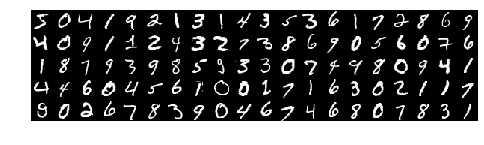

Epoch 0 : Sampling Image: 


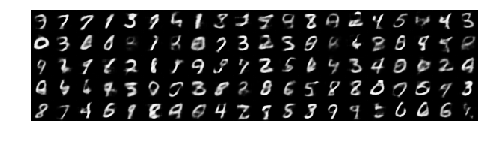

Epoch 0 : Reconstruct Image: 


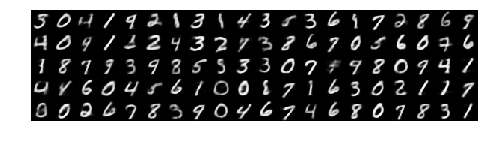

[1/25] - ptime: 18.20 Total_loss=(L+KL): 137.355 = (120.830+16.526)
Epoch 1 : Sampling Image: 


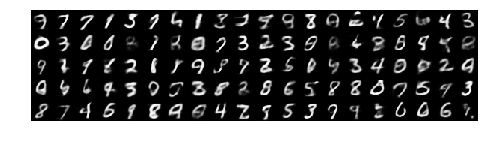

Epoch 1 : Reconstruct Image: 


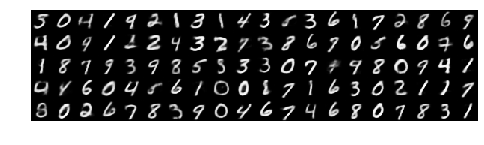

[2/25] - ptime: 16.61 Total_loss=(L+KL): 118.177 = (101.085+17.092)
Epoch 2 : Sampling Image: 


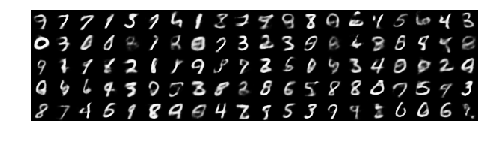

Epoch 2 : Reconstruct Image: 


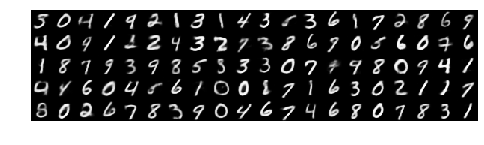

[3/25] - ptime: 16.65 Total_loss=(L+KL): 114.073 = (96.741+17.331)
Epoch 3 : Sampling Image: 


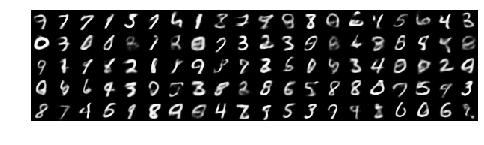

Epoch 3 : Reconstruct Image: 


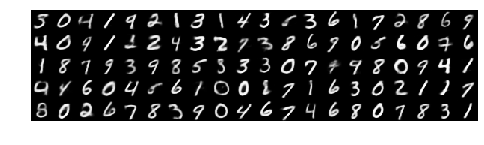

[4/25] - ptime: 16.72 Total_loss=(L+KL): 111.609 = (94.094+17.516)
Epoch 4 : Sampling Image: 


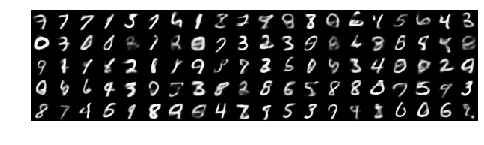

Epoch 4 : Reconstruct Image: 


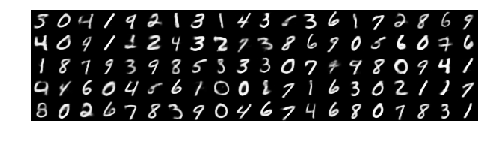

[5/25] - ptime: 16.64 Total_loss=(L+KL): 109.857 = (92.213+17.644)
Epoch 5 : Sampling Image: 


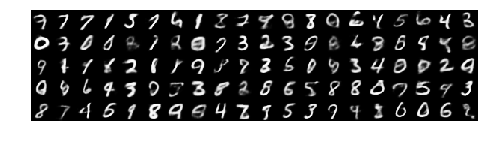

Epoch 5 : Reconstruct Image: 


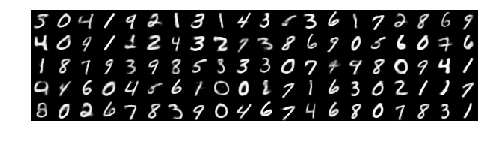

[6/25] - ptime: 16.37 Total_loss=(L+KL): 108.483 = (90.750+17.733)
Epoch 6 : Sampling Image: 


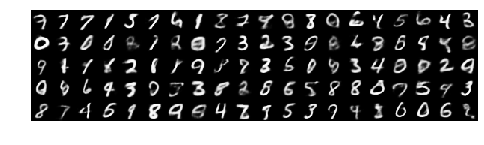

Epoch 6 : Reconstruct Image: 


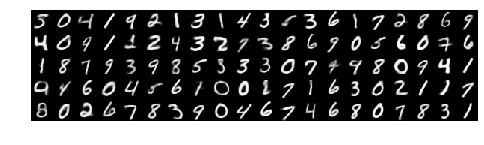

[7/25] - ptime: 16.56 Total_loss=(L+KL): 107.326 = (89.538+17.788)
Epoch 7 : Sampling Image: 


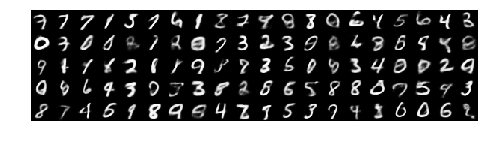

Epoch 7 : Reconstruct Image: 


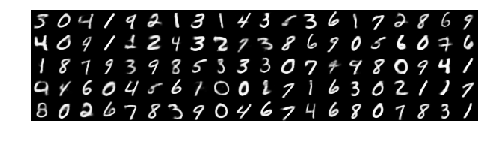

[8/25] - ptime: 16.76 Total_loss=(L+KL): 106.308 = (88.486+17.822)
Epoch 8 : Sampling Image: 


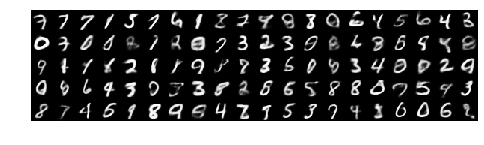

Epoch 8 : Reconstruct Image: 


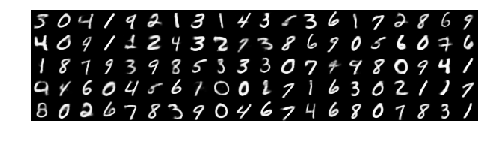

[9/25] - ptime: 16.59 Total_loss=(L+KL): 105.381 = (87.546+17.835)
Epoch 9 : Sampling Image: 


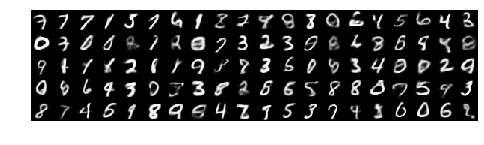

Epoch 9 : Reconstruct Image: 


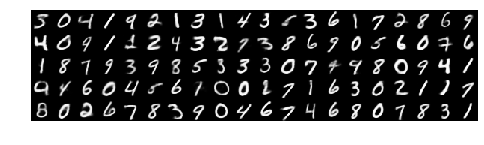

[10/25] - ptime: 16.72 Total_loss=(L+KL): 104.519 = (86.685+17.834)
Epoch 10 : Sampling Image: 


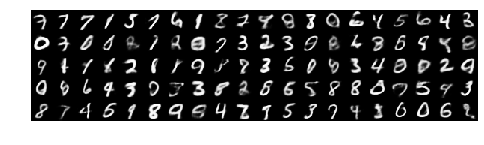

Epoch 10 : Reconstruct Image: 


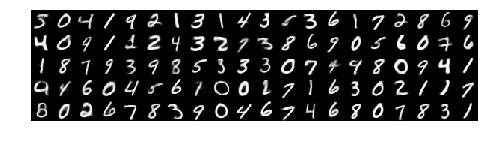

[11/25] - ptime: 16.71 Total_loss=(L+KL): 103.712 = (85.895+17.817)
Epoch 11 : Sampling Image: 


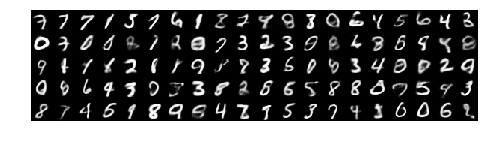

Epoch 11 : Reconstruct Image: 


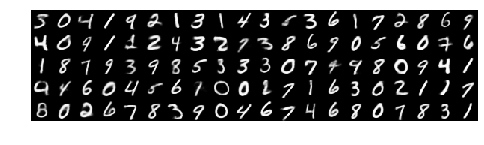

[12/25] - ptime: 16.78 Total_loss=(L+KL): 102.937 = (85.149+17.787)
Epoch 12 : Sampling Image: 


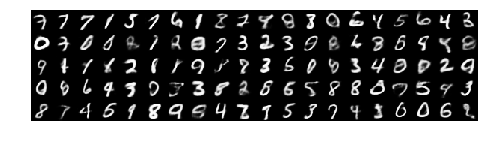

Epoch 12 : Reconstruct Image: 


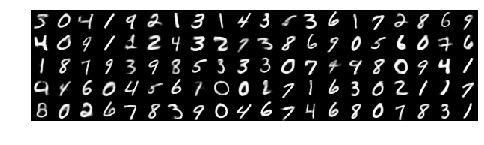

[13/25] - ptime: 16.76 Total_loss=(L+KL): 102.191 = (84.446+17.745)
Epoch 13 : Sampling Image: 


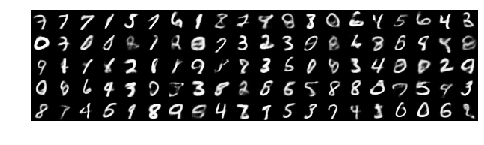

Epoch 13 : Reconstruct Image: 


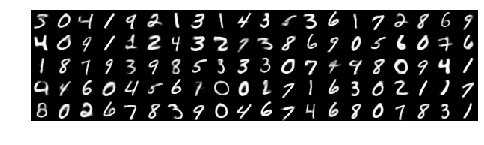

[14/25] - ptime: 16.64 Total_loss=(L+KL): 101.465 = (83.778+17.688)
Epoch 14 : Sampling Image: 


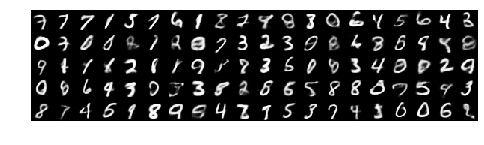

Epoch 14 : Reconstruct Image: 


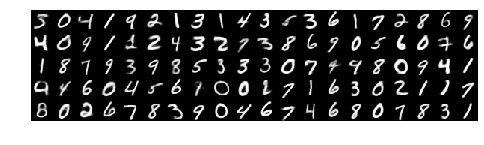

[15/25] - ptime: 16.55 Total_loss=(L+KL): 100.754 = (83.137+17.617)
Epoch 15 : Sampling Image: 


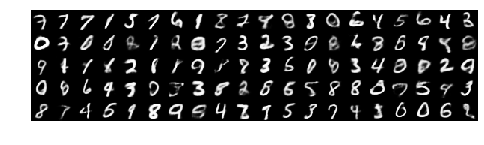

Epoch 15 : Reconstruct Image: 


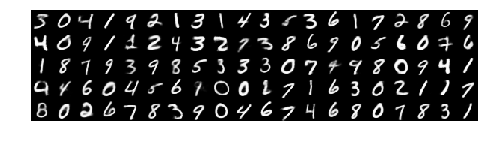

[16/25] - ptime: 16.88 Total_loss=(L+KL): 100.059 = (82.525+17.534)
Epoch 16 : Sampling Image: 


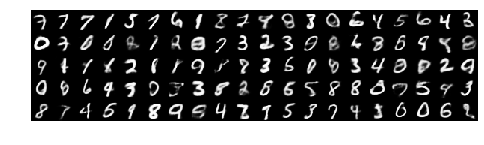

Epoch 16 : Reconstruct Image: 


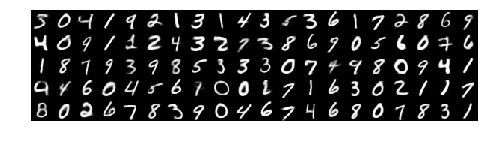

[17/25] - ptime: 16.77 Total_loss=(L+KL): 99.373 = (81.938+17.435)
Epoch 17 : Sampling Image: 


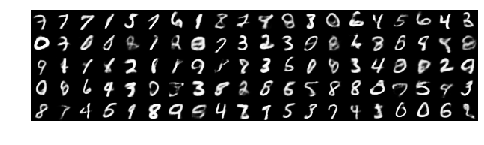

Epoch 17 : Reconstruct Image: 


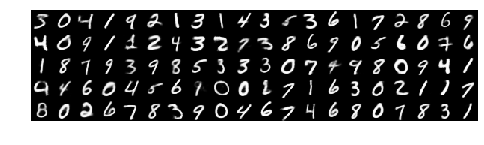

[18/25] - ptime: 16.71 Total_loss=(L+KL): 98.702 = (81.376+17.326)
Epoch 18 : Sampling Image: 


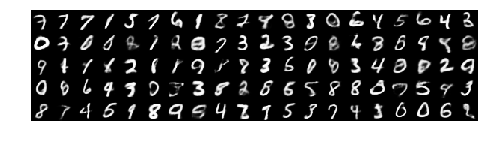

Epoch 18 : Reconstruct Image: 


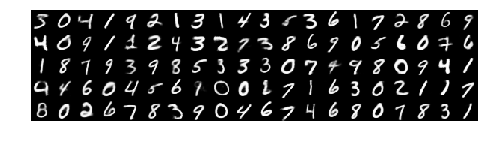

[19/25] - ptime: 16.66 Total_loss=(L+KL): 98.044 = (80.847+17.198)
Epoch 19 : Sampling Image: 


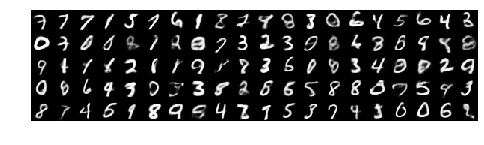

Epoch 19 : Reconstruct Image: 


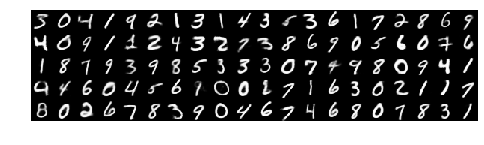

[20/25] - ptime: 16.79 Total_loss=(L+KL): 97.405 = (80.348+17.057)
Epoch 20 : Sampling Image: 


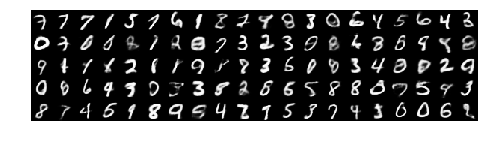

Epoch 20 : Reconstruct Image: 


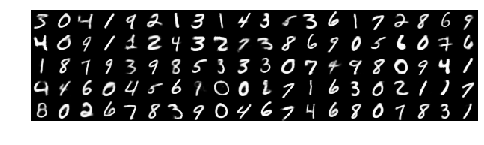

[21/25] - ptime: 16.83 Total_loss=(L+KL): 96.779 = (79.877+16.903)
Epoch 21 : Sampling Image: 


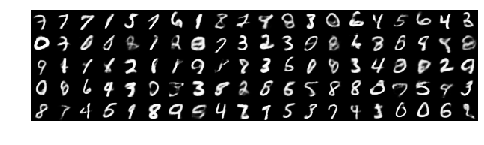

Epoch 21 : Reconstruct Image: 


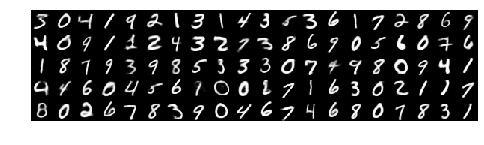

[22/25] - ptime: 16.55 Total_loss=(L+KL): 96.201 = (79.457+16.744)
Epoch 22 : Sampling Image: 


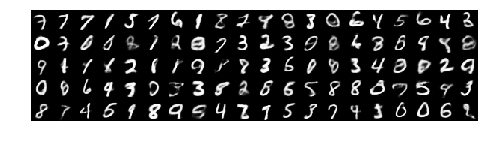

Epoch 22 : Reconstruct Image: 


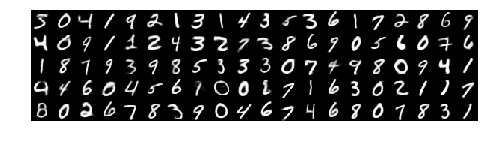

[23/25] - ptime: 16.37 Total_loss=(L+KL): 95.668 = (79.090+16.578)
Epoch 23 : Sampling Image: 


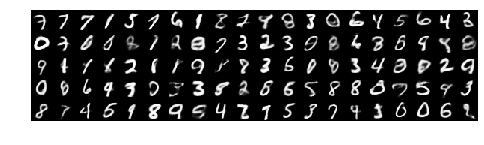

Epoch 23 : Reconstruct Image: 


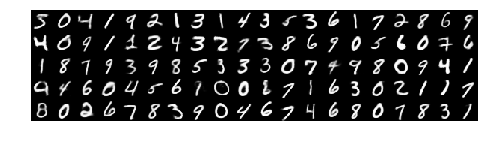

[24/25] - ptime: 16.83 Total_loss=(L+KL): 95.234 = (78.810+16.424)
Epoch 24 : Sampling Image: 


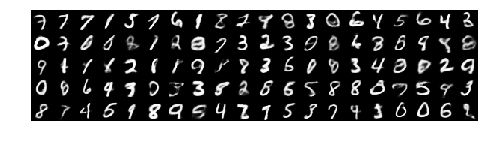

Epoch 24 : Reconstruct Image: 


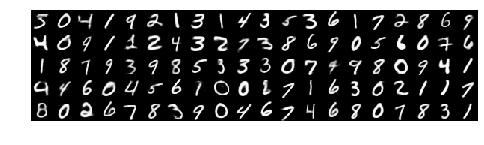

[25/25] - ptime: 16.75 Total_loss=(L+KL): 94.876 = (78.587+16.289)


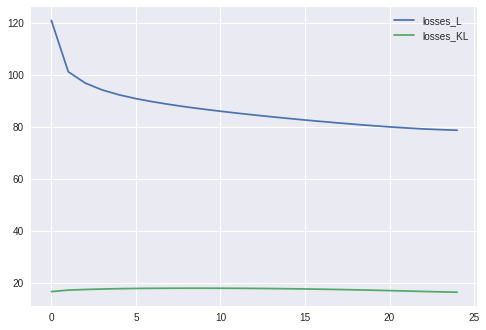

In [0]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    vae = VAE(sess,
              image_size=28,
              batch_size=100,
              sample_size=100,
              z_dim=10,
              )
    vae.train(num_epoch=25, lr=0.002, beta1=0.5)